Práctica 4:
* Francisco Roman Peña de la Rosa
* Modelos de Clasificación:
* Dataset: fake_news


   * **Regresión Logística**
   * **Análisis Discriminante Lineal (LDR)**
   * **KNN Classifier**
   * **Support Vector Machines (SVM)**
   * **Naive Bayes Classifier**
   * **Árboles de Decisión**

## Cargamos librerias a utilizar

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import emoji

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

pd.set_option("display.max_columns", 50)
pd.set_option('max_rows',9999)
pd.set_option('display.float_format', lambda x: "{:,.5f}".format(x))

[nltk_data] Downloading package wordnet to C:\Users\Dell
[nltk_data]     User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Leemos datos

In [2]:
# Cargamos "fake_news_train" dataset
df_train= pd.read_csv('fake_news_train.csv', delimiter= ',')
print(df_train.shape)
df_train.head(3)

(35918, 5)


,title,text,subject,date,fake_not
0,Barca's Valverde skirts independence debate as...,"MADRID, (Reuters) - Barcelona boss Ernesto Val...",worldnews,"October 27, 2017",0
1,Trump says Brexit wouldn't impact potential UK...,LONDON (Reuters) - Presumptive U.S. Republican...,politicsNews,"May 15, 2016",0
2,Mark Zuckerberg’s PERFECT Facebook Comment To...,There are seldom people in life that you can h...,News,"January 4, 2016",1


In [3]:
# Cargamos fake_news_test" dataset
df_test= pd.read_csv('fake_news_test.csv', delimiter= ',', encoding= 'latin_1')
print(df_test.shape)
df_test.head(3)

(8980, 3)


,title,text,subject
0,Vietnam police arrest ex-politburo member over...,HANOI (Reuters) - Vietnamese police on Friday ...,worldnews
1,IS FOX ABOUT TO BECOME CNN? Leftist Wives Of L...,It is difficult to exaggerate the significance...,left-news
2,North Carolina Tea Partiers Just ADMITTED The...,Since Donald Trump began his run for the presi...,News


## Analizamos proporción de la variable objetivo

In [4]:
df_train['fake_not'].value_counts(1) # Las clases se encuentran balanceadas

1   0.52280
0   0.47720
Name: fake_not, dtype: float64

## Preprocesamiento de los datos

In [5]:
# Verificamos la presencia de valores ausentes
df_train.isnull().sum()

title       0
text        0
subject     0
date        0
fake_not    0
dtype: int64

In [6]:
# Inspeccionamos proporción de "subject"
df_train['subject'].value_counts(1) # se requerirá normalizar la variable

politicsNews      0.25188
worldnews         0.22532
News              0.20243
politics          0.15176
left-news         0.09981
Government News   0.03491
US_News           0.01707
Middle-east       0.01682
Name: subject, dtype: float64

In [7]:
# Inspeccionamos proporción de "date"
df_train['date'].describe()

count                 35918
unique                 2385
top       December 6, 2017 
freq                    143
Name: date, dtype: object

In [8]:
# Convertimos "date" a un formato de fecha válido
# aplicamos "coerce" para los no válidos de formato fecha y se establecen como NaT
# posteriormente los eliminamos: pasándo de 35,918 iniciales a 35,910

df_train['date']=pd.to_datetime(df_train['date'], errors= 'coerce')
df_train= df_train.dropna(subset=['date'])
print(df_train.shape)
df_train.head(5)

(35910, 5)


,title,text,subject,date,fake_not
0,Barca's Valverde skirts independence debate as...,"MADRID, (Reuters) - Barcelona boss Ernesto Val...",worldnews,2017-10-27,0
1,Trump says Brexit wouldn't impact potential UK...,LONDON (Reuters) - Presumptive U.S. Republican...,politicsNews,2016-05-15,0
2,Mark Zuckerberg’s PERFECT Facebook Comment To...,There are seldom people in life that you can h...,News,2016-01-04,1
3,Suspected U.S. drone targets Haqqani militants...,"DERA ISMAIL KHAN, Pakistan (Reuters) - A suspe...",worldnews,2017-11-30,0
4,U.S. special envoy encouraged that Kurds could...,"ERBIL (Reuters) - Brett McGurk, the U.S. speci...",worldnews,2017-09-14,0


In [9]:
# Identificamos el inicio del histórico de nuestros datos (primer registro)
df_train['date'].min()

Timestamp('2015-03-31 00:00:00')

In [10]:
# Identificamos el final del histórico de nuestros datos (último registro)
df_train['date'].max()

Timestamp('2018-02-19 00:00:00')

## Ingeniería de variables

In [11]:
# Eliminamos signos de puntuación y retornamos el texto en minúsculas
import re, unicodedata
def clean_words(text):
    res =  unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
    res = re.sub("[^a-zA-Z0-9 ]"," ", res.decode("utf-8"), flags=re.UNICODE)
    res =  u' '.join(res.lower().split())
    return res

In [12]:
# Limpiamos texto de la columna "title"
df_train['clean_title']= df_train['title'].map(clean_words)
df_train.head(3)

,title,text,subject,date,fake_not,clean_title
0,Barca's Valverde skirts independence debate as...,"MADRID, (Reuters) - Barcelona boss Ernesto Val...",worldnews,2017-10-27,0,barca s valverde skirts independence debate as...
1,Trump says Brexit wouldn't impact potential UK...,LONDON (Reuters) - Presumptive U.S. Republican...,politicsNews,2016-05-15,0,trump says brexit wouldn t impact potential uk...
2,Mark Zuckerberg’s PERFECT Facebook Comment To...,There are seldom people in life that you can h...,News,2016-01-04,1,mark zuckerbergs perfect facebook comment to g...


In [13]:
# Obtenemos tokens de la variable "clean_title"
tokenizer=RegexpTokenizer(r'\w+')
df_train['title_tokens']= df_train['clean_title'].apply(lambda x:tokenizer.tokenize(x.lower()))
df_train.head(3)

,title,text,subject,date,fake_not,clean_title,title_tokens
0,Barca's Valverde skirts independence debate as...,"MADRID, (Reuters) - Barcelona boss Ernesto Val...",worldnews,2017-10-27,0,barca s valverde skirts independence debate as...,"[barca, s, valverde, skirts, independence, deb..."
1,Trump says Brexit wouldn't impact potential UK...,LONDON (Reuters) - Presumptive U.S. Republican...,politicsNews,2016-05-15,0,trump says brexit wouldn t impact potential uk...,"[trump, says, brexit, wouldn, t, impact, poten..."
2,Mark Zuckerberg’s PERFECT Facebook Comment To...,There are seldom people in life that you can h...,News,2016-01-04,1,mark zuckerbergs perfect facebook comment to g...,"[mark, zuckerbergs, perfect, facebook, comment..."


In [14]:
# Limpiamos texto de la columna "text"
df_train['clean_text']= df_train['text'].map(clean_words)
df_train.head(3)

,title,text,subject,date,fake_not,clean_title,title_tokens,clean_text
0,Barca's Valverde skirts independence debate as...,"MADRID, (Reuters) - Barcelona boss Ernesto Val...",worldnews,2017-10-27,0,barca s valverde skirts independence debate as...,"[barca, s, valverde, skirts, independence, deb...",madrid reuters barcelona boss ernesto valverde...
1,Trump says Brexit wouldn't impact potential UK...,LONDON (Reuters) - Presumptive U.S. Republican...,politicsNews,2016-05-15,0,trump says brexit wouldn t impact potential uk...,"[trump, says, brexit, wouldn, t, impact, poten...",london reuters presumptive u s republican pres...
2,Mark Zuckerberg’s PERFECT Facebook Comment To...,There are seldom people in life that you can h...,News,2016-01-04,1,mark zuckerbergs perfect facebook comment to g...,"[mark, zuckerbergs, perfect, facebook, comment...",there are seldom people in life that you can h...


In [15]:
# Obtenemos tokens de la variable "clean_text"
df_train['text_tokens']= df_train['clean_text'].apply(lambda x:tokenizer.tokenize(x.lower()))
df_train.head(3)

,title,text,subject,date,fake_not,clean_title,title_tokens,clean_text,text_tokens
0,Barca's Valverde skirts independence debate as...,"MADRID, (Reuters) - Barcelona boss Ernesto Val...",worldnews,2017-10-27,0,barca s valverde skirts independence debate as...,"[barca, s, valverde, skirts, independence, deb...",madrid reuters barcelona boss ernesto valverde...,"[madrid, reuters, barcelona, boss, ernesto, va..."
1,Trump says Brexit wouldn't impact potential UK...,LONDON (Reuters) - Presumptive U.S. Republican...,politicsNews,2016-05-15,0,trump says brexit wouldn t impact potential uk...,"[trump, says, brexit, wouldn, t, impact, poten...",london reuters presumptive u s republican pres...,"[london, reuters, presumptive, u, s, republica..."
2,Mark Zuckerberg’s PERFECT Facebook Comment To...,There are seldom people in life that you can h...,News,2016-01-04,1,mark zuckerbergs perfect facebook comment to g...,"[mark, zuckerbergs, perfect, facebook, comment...",there are seldom people in life that you can h...,"[there, are, seldom, people, in, life, that, y..."


In [16]:
lemmatizer=WordNetLemmatizer()
def word_lemmatizer(text):
    lem_text=' '.join([lemmatizer.lemmatize(i) for i in text])
    return lem_text

In [17]:
# Lematización para "title_tokens"
df_train['lemma_title']=df_train['title_tokens'].apply(lambda x:word_lemmatizer(x))
df_train.head(3)

,title,text,subject,date,fake_not,clean_title,title_tokens,clean_text,text_tokens,lemma_title
0,Barca's Valverde skirts independence debate as...,"MADRID, (Reuters) - Barcelona boss Ernesto Val...",worldnews,2017-10-27,0,barca s valverde skirts independence debate as...,"[barca, s, valverde, skirts, independence, deb...",madrid reuters barcelona boss ernesto valverde...,"[madrid, reuters, barcelona, boss, ernesto, va...",barca s valverde skirt independence debate a i...
1,Trump says Brexit wouldn't impact potential UK...,LONDON (Reuters) - Presumptive U.S. Republican...,politicsNews,2016-05-15,0,trump says brexit wouldn t impact potential uk...,"[trump, says, brexit, wouldn, t, impact, poten...",london reuters presumptive u s republican pres...,"[london, reuters, presumptive, u, s, republica...",trump say brexit wouldn t impact potential uk ...
2,Mark Zuckerberg’s PERFECT Facebook Comment To...,There are seldom people in life that you can h...,News,2016-01-04,1,mark zuckerbergs perfect facebook comment to g...,"[mark, zuckerbergs, perfect, facebook, comment...",there are seldom people in life that you can h...,"[there, are, seldom, people, in, life, that, y...",mark zuckerbergs perfect facebook comment to g...


In [18]:
# Lematización para "text_tokens"
df_train['lemma_text']=df_train['text_tokens'].apply(lambda x:word_lemmatizer(x))
df_train.head(3)

,title,text,subject,date,fake_not,clean_title,title_tokens,clean_text,text_tokens,lemma_title,lemma_text
0,Barca's Valverde skirts independence debate as...,"MADRID, (Reuters) - Barcelona boss Ernesto Val...",worldnews,2017-10-27,0,barca s valverde skirts independence debate as...,"[barca, s, valverde, skirts, independence, deb...",madrid reuters barcelona boss ernesto valverde...,"[madrid, reuters, barcelona, boss, ernesto, va...",barca s valverde skirt independence debate a i...,madrid reuters barcelona bos ernesto valverde ...
1,Trump says Brexit wouldn't impact potential UK...,LONDON (Reuters) - Presumptive U.S. Republican...,politicsNews,2016-05-15,0,trump says brexit wouldn t impact potential uk...,"[trump, says, brexit, wouldn, t, impact, poten...",london reuters presumptive u s republican pres...,"[london, reuters, presumptive, u, s, republica...",trump say brexit wouldn t impact potential uk ...,london reuters presumptive u s republican pres...
2,Mark Zuckerberg’s PERFECT Facebook Comment To...,There are seldom people in life that you can h...,News,2016-01-04,1,mark zuckerbergs perfect facebook comment to g...,"[mark, zuckerbergs, perfect, facebook, comment...",there are seldom people in life that you can h...,"[there, are, seldom, people, in, life, that, y...",mark zuckerbergs perfect facebook comment to g...,there are seldom people in life that you can h...


In [19]:
# Conteo de puntos den el texto original
df_train['n_dots'] = df_train['text'].map(lambda x: x.count('.'))
df_train.head(3)

,title,text,subject,date,fake_not,clean_title,title_tokens,clean_text,text_tokens,lemma_title,lemma_text,n_dots
0,Barca's Valverde skirts independence debate as...,"MADRID, (Reuters) - Barcelona boss Ernesto Val...",worldnews,2017-10-27,0,barca s valverde skirts independence debate as...,"[barca, s, valverde, skirts, independence, deb...",madrid reuters barcelona boss ernesto valverde...,"[madrid, reuters, barcelona, boss, ernesto, va...",barca s valverde skirt independence debate a i...,madrid reuters barcelona bos ernesto valverde ...,14
1,Trump says Brexit wouldn't impact potential UK...,LONDON (Reuters) - Presumptive U.S. Republican...,politicsNews,2016-05-15,0,trump says brexit wouldn t impact potential uk...,"[trump, says, brexit, wouldn, t, impact, poten...",london reuters presumptive u s republican pres...,"[london, reuters, presumptive, u, s, republica...",trump say brexit wouldn t impact potential uk ...,london reuters presumptive u s republican pres...,8
2,Mark Zuckerberg’s PERFECT Facebook Comment To...,There are seldom people in life that you can h...,News,2016-01-04,1,mark zuckerbergs perfect facebook comment to g...,"[mark, zuckerbergs, perfect, facebook, comment...",there are seldom people in life that you can h...,"[there, are, seldom, people, in, life, that, y...",mark zuckerbergs perfect facebook comment to g...,there are seldom people in life that you can h...,20


In [20]:
df_train['n_letters'] = df_train['text'].map(lambda x:sum(map(str.isalpha, x)))
df_train['n_lower_ratio_letters'] = df_train['text'].map(lambda x:sum(map(str.islower, x))) / df_train['n_letters']
df_train['n_upper_ratio_letters'] = df_train['text'].map(lambda x:sum(map(str.isupper, x))) / df_train['n_letters']
df_train['n_words_title']= df_train['clean_title'].str.split().map(len)
df_train['n_words_text']= df_train['clean_text'].str.split().map(len)
df_train['n_emojis'] = df_train['text'].map(emoji.emoji_count)
df_train.head(3)

,title,text,subject,date,fake_not,clean_title,title_tokens,clean_text,text_tokens,lemma_title,lemma_text,n_dots,n_letters,n_lower_ratio_letters,n_upper_ratio_letters,n_words_title,n_words_text,n_emojis
0,Barca's Valverde skirts independence debate as...,"MADRID, (Reuters) - Barcelona boss Ernesto Val...",worldnews,2017-10-27,0,barca s valverde skirts independence debate as...,"[barca, s, valverde, skirts, independence, deb...",madrid reuters barcelona boss ernesto valverde...,"[madrid, reuters, barcelona, boss, ernesto, va...",barca s valverde skirt independence debate a i...,madrid reuters barcelona bos ernesto valverde ...,14,1574,0.95426,0.04574,12,337,0
1,Trump says Brexit wouldn't impact potential UK...,LONDON (Reuters) - Presumptive U.S. Republican...,politicsNews,2016-05-15,0,trump says brexit wouldn t impact potential uk...,"[trump, says, brexit, wouldn, t, impact, poten...",london reuters presumptive u s republican pres...,"[london, reuters, presumptive, u, s, republica...",trump say brexit wouldn t impact potential uk ...,london reuters presumptive u s republican pres...,8,585,0.92650,0.07350,17,136,0
2,Mark Zuckerberg’s PERFECT Facebook Comment To...,There are seldom people in life that you can h...,News,2016-01-04,1,mark zuckerbergs perfect facebook comment to g...,"[mark, zuckerbergs, perfect, facebook, comment...",there are seldom people in life that you can h...,"[there, are, seldom, people, in, life, that, y...",mark zuckerbergs perfect facebook comment to g...,there are seldom people in life that you can h...,20,1808,0.95299,0.04701,12,400,0


In [29]:
import stylecloud
from PIL.Image import open as open_wordcloud

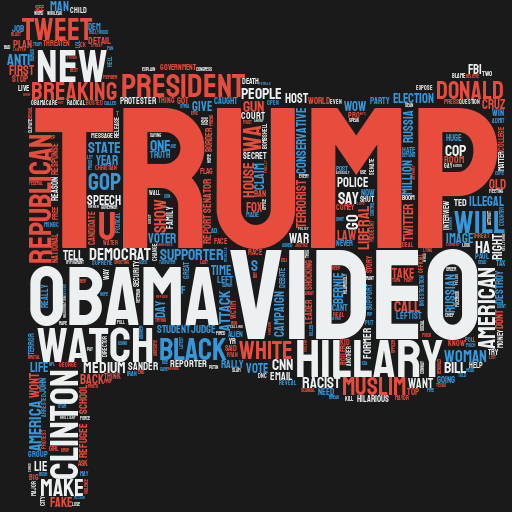

In [30]:
# Wordcloud "lemma_title" => label 1
title_one=' '.join(df_train[df_train['fake_not']==1]['lemma_title'].to_list())

stylecloud.gen_stylecloud(text= title_one,
                          collocations=False,
                          colors=['#ecf0f1', '#3498db', '#e74c3c'],
                          palette='colorbrewer.diverging.Spectral_11',
                          background_color='#1A1A1A',
                          gradient='horizontal')

open_wordcloud('stylecloud.png')

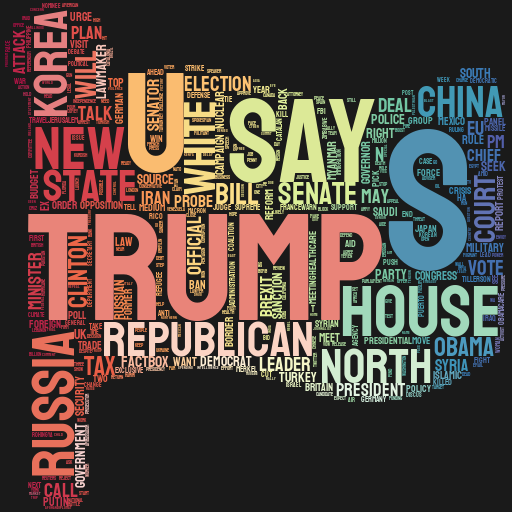

In [31]:
# Wordcloud "lemma_title" => label 0
title_zero=' '.join(df_train[df_train['fake_not']==0]['lemma_title'].to_list())

stylecloud.gen_stylecloud(text= title_zero,
                          collocations=False,
                          palette='colorbrewer.diverging.Spectral_10',
                          background_color='#1A1A1A',
                          gradient='horizontal')

open_wordcloud('stylecloud.png')

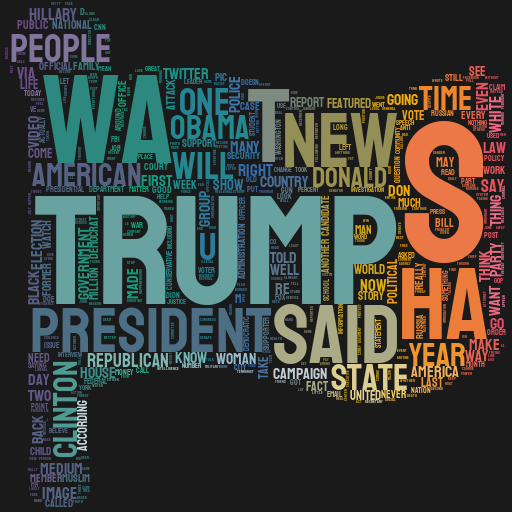

In [32]:
# Wordcloud "lemma_text" => label 1
text_one=' '.join(df_train[df_train['fake_not']==1]['lemma_text'].to_list())

stylecloud.gen_stylecloud(text= text_one,
                          collocations=False,
                          palette='cartocolors.qualitative.Bold_5',
                          background_color='#1A1A1A',
                          gradient='horizontal')

open_wordcloud('stylecloud.png')

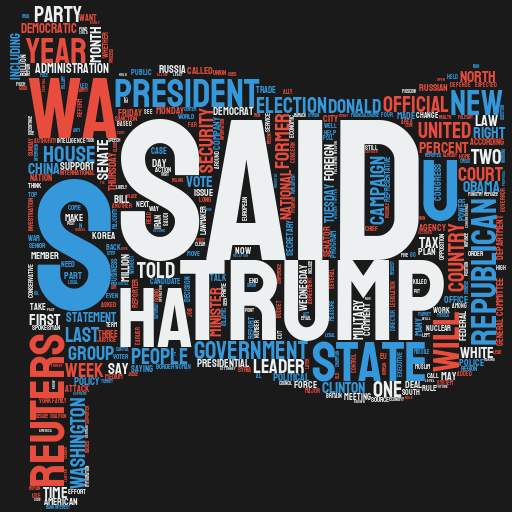

In [33]:
# Wordcloud "lemma_text" => label 0

text_zero=' '.join(df_train[df_train['fake_not']==0]['lemma_text'].to_list())

stylecloud.gen_stylecloud(text= text_zero,
                          collocations=False,
                          colors=['#ecf0f1', '#3498db', '#e74c3c'],
                          palette='colorbrewer.diverging.Spectral_11',
                          background_color='#1A1A1A',
                          gradient='horizontal')


open_wordcloud('stylecloud.png')

## Modelado

* Se utiliza sólo training_set para analizar el desempeño de algunos modelos
* En la etapa posterior se implementa el modelo con mejor desempeño en el test_set

In [34]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

### Tf-IDF Vectorizer

In [35]:
stopwords= stopwords.words('english')

In [36]:
cv = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 1), min_df=10, max_features=100)

In [37]:
df_train.columns

Index(['title', 'text', 'subject', 'date', 'fake_not', 'clean_title',
       'title_tokens', 'clean_text', 'text_tokens', 'lemma_title',
       'lemma_text', 'n_dots', 'n_letters', 'n_lower_ratio_letters',
       'n_upper_ratio_letters', 'n_words_title', 'n_words_text', 'n_emojis'],
      dtype='object')

In [38]:
ls_features=['n_dots', 'n_letters', 'n_lower_ratio_letters',
       'n_upper_ratio_letters', 'n_words_title', 'n_words_text', 'n_emojis']

In [39]:
df_train[ls_features].isnull().sum()

n_dots                     0
n_letters                  0
n_lower_ratio_letters    510
n_upper_ratio_letters    510
n_words_title              0
n_words_text               0
n_emojis                   0
dtype: int64

In [40]:
df_train['n_lower_ratio_letters']= df_train['n_lower_ratio_letters'].fillna(value= 0)
df_train['n_upper_ratio_letters']= df_train['n_lower_ratio_letters'].fillna(value= 0)

In [41]:
df_train[ls_features].isnull().sum()

n_dots                   0
n_letters                0
n_lower_ratio_letters    0
n_upper_ratio_letters    0
n_words_title            0
n_words_text             0
n_emojis                 0
dtype: int64

In [43]:
cv.fit(df_train['clean_text'])

TfidfVectorizer(max_features=100, min_df=10,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [44]:
X = df_train[ls_features].join(pd.DataFrame(data = cv.transform(df_train['clean_text']).todense(), columns = cv.get_feature_names()))
y = df_train['fake_not']

In [45]:
print(X.shape)
print(y.shape)

(35910, 107)
(35910,)


In [46]:
X

,n_dots,n_letters,n_lower_ratio_letters,n_upper_ratio_letters,n_words_title,n_words_text,n_emojis,000,according,administration,also,america,american,back,bill,called,campaign,clinton,could,country,court,day,democratic,department,donald,...,support,take,tax,think,time,told,trump,trumps,tuesday,twitter,two,united,us,via,vote,want,washington,way,week,well,white,world,would,year,years
0,14,1574,0.95426,0.95426,12,337,0,0.00000,0.00000,0.00000,0.15195,0.00000,0.00000,0.20394,0.00000,0.20443,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.17499,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.22409,0.00000,0.00000,0.20574,0.00000,0.00000,0.00000,0.27095,0.17587,0.19352
1,8,585,0.92650,0.92650,17,136,0,0.00000,0.20661,0.00000,0.00000,0.00000,0.00000,0.40947,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.15344,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.16964,0.28097,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.40801,0.00000,0.00000
2,20,1808,0.95299,0.95299,12,400,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.13378,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.16067,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.13594,0.00000,0.16470,0.29173,0.00000,0.00000,0.00000,0.15949,0.00000,0.15936,0.00000,0.00000,0.10414,0.13520,0.14877
3,19,1470,0.94626,0.94626,11,288,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.14269,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.10567,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.19348,0.00000,0.00000,0.00000,0.36675,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.09366,0.00000,0.00000
4,5,344,0.93605,0.93605,13,71,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.36551,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.45262,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.28453,0.00000,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35913,8,1075,0.94140,0.94140,13,219,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35914,8,906,0.96137,0.96137,8,180,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35915,20,1486,0.95962,0.95962,10,321,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35916,20,1378,0.96226,0.96226,8,290,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
X= X.fillna(value= 0)

In [48]:
# Separamos nuestros datos en 'training set' y 'test set'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 207)

### Regresión Logística

In [49]:
logistic= LogisticRegression()

In [50]:
# Ajustamos el modelo con nuestros datos de entrenamiento
logistic.fit(X_train,y_train)

LogisticRegression()

In [51]:
# Realizamos la predicción utilizando el conjunto de prueba
logistic.predict(X_test)

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [52]:
pred_logistic = logistic.predict(X_test)
pred_logistic

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [53]:
from sklearn.metrics import roc_auc_score,accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import plot_roc_curve

In [54]:
def metricas(model,Xv,yv): #Mide efectividad de un Modelo Predictivo
    print( " Roc Validate: %.3f" %roc_auc_score(y_score=model.predict_proba(Xv)[:,1],y_true=yv))
    print( " Acc Validate: %.3f" %accuracy_score(y_pred=model.predict(Xv),y_true=yv))
    print( " Matrix Conf Validate: ", "\n",confusion_matrix(y_pred=model.predict(Xv),y_true=yv))

In [55]:
metricas(logistic,X_test,y_test)

 Roc Validate: 0.900
 Acc Validate: 0.827
 Matrix Conf Validate:  
 [[4327  782]
 [1080 4584]]


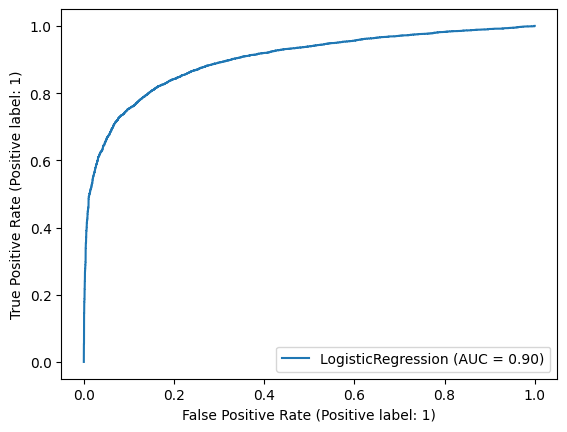

In [56]:
import matplotlib.pyplot as plt
plot_roc_curve(logistic,X_test,y_test,drop_intermediate=False)
plt.show()

### Hiperparametrizando - Regresión L.

In [57]:
import numpy as np

In [58]:
print(logistic.get_params().keys())

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])


In [59]:
param_grid_lr = {
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'penalty': ['l2','l1'],
    'C': np.arange(0.1,1,0.1)
}

In [61]:
np.prod(list(map(len, param_grid_lr.values())))

54

In [62]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [63]:
lgc = RandomizedSearchCV(logistic, param_grid_lr, cv=4, error_score=-1000, n_jobs=-1, scoring= 'accuracy', verbose= 5)
lgc.fit(X_train, y_train)
print("Best score: " + str(lgc.best_score_))

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best score: 0.8312449518849756


In [64]:
lgc.best_estimator_

LogisticRegression(C=0.30000000000000004, penalty='l1', solver='liblinear')

In [71]:
lgc.best_params_

{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.30000000000000004}

In [72]:
dc_scores={}

In [73]:
dc_scores[str(logistic).split("(")[0]] = {'model': lgc.best_estimator_, 'score': lgc.best_score_}
dc_scores

{'LogisticRegression': {'model': LogisticRegression(C=0.30000000000000004, penalty='l1', solver='liblinear'),
  'score': 0.8312449518849756}}

In [75]:
# Usando los hiperparametros para el modelo
logistic = LogisticRegression(C=0.3,penalty='l1',solver='liblinear')
logistic.fit(X_train, y_train)

LogisticRegression(C=0.3, penalty='l1', solver='liblinear')

In [76]:
# Realizamos la predicción utilizando el conjunto de prueba
logistic.predict(X_test)

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [77]:
pred_logistic = logistic.predict(X_test)
pred_logistic

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [78]:
def metricas(model,Xv,yv): #Mide efectividad de un Modelo Predictivo
    print( " Roc Validate: %.3f" %roc_auc_score(y_score=model.predict_proba(Xv)[:,1],y_true=yv))
    print( " Acc Validate: %.3f" %accuracy_score(y_pred=model.predict(Xv),y_true=yv))
    print( " Matrix Conf Validate: ", "\n",confusion_matrix(y_pred=model.predict(Xv),y_true=yv))

In [79]:
metricas(logistic,X_test,y_test)

 Roc Validate: 0.903
 Acc Validate: 0.828
 Matrix Conf Validate:  
 [[4329  780]
 [1075 4589]]


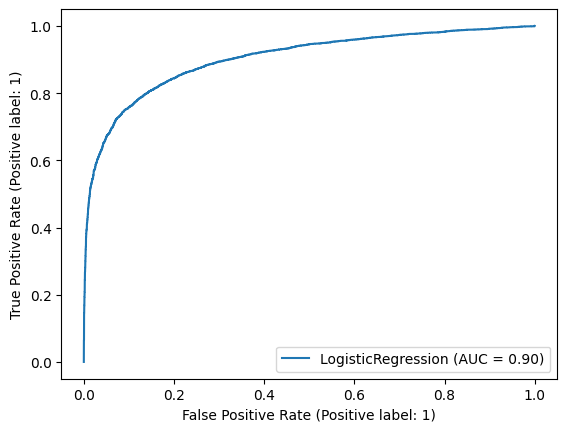

In [80]:
import matplotlib.pyplot as plt
plot_roc_curve(logistic,X_test,y_test,drop_intermediate=False)
plt.show()

In [91]:
print('--Logistic Regression--')
print('\n')
print(confusion_matrix(y_test,pred_logistic))
print('\n')
print(classification_report(y_test,pred_logistic))

--Logistic Regression--


[[4329  780]
 [1075 4589]]


              precision    recall  f1-score   support

           0       0.80      0.85      0.82      5109
           1       0.85      0.81      0.83      5664

    accuracy                           0.83     10773
   macro avg       0.83      0.83      0.83     10773
weighted avg       0.83      0.83      0.83     10773



### Análisis Discriminante Linea (LDR)

In [81]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [82]:
lda= LinearDiscriminantAnalysis()

In [120]:
lda_X_train=X_train
lda_y_train=y_train
lda_X_test=X_test
lda_y_test=y_test

In [121]:
lda.fit(lda_X_train,lda_y_train)

LinearDiscriminantAnalysis()

In [122]:
pred_lda= lda.predict(lda_X_test)
pred_lda

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [123]:
metricas(lda,lda_X_train,lda_y_train)

 Roc Validate: 0.903
 Acc Validate: 0.828
 Matrix Conf Validate:  
 [[10546  1485]
 [ 2839 10267]]


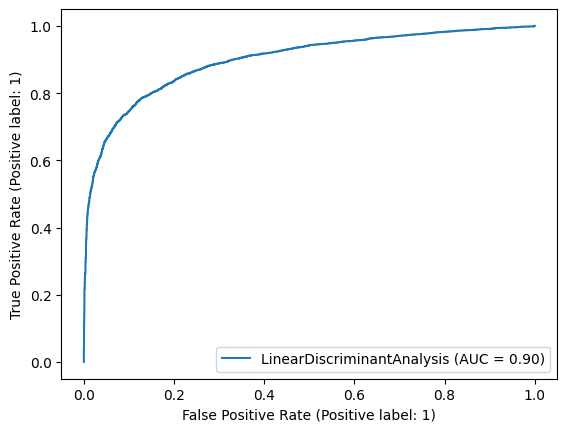

In [124]:
import matplotlib.pyplot as plt
plot_roc_curve(lda,lda_X_test,lda_y_test,drop_intermediate=False)
plt.show()

In [125]:
print('--Linear Discriminant Analysis - LDA--')
print('\n')
print(confusion_matrix(y_test,pred_lda))

print('\n')
print(classification_report(y_test,pred_lda))

--Linear Discriminant Analysis - LDA--


[[4498  611]
 [1275 4389]]


              precision    recall  f1-score   support

           0       0.78      0.88      0.83      5109
           1       0.88      0.77      0.82      5664

    accuracy                           0.82     10773
   macro avg       0.83      0.83      0.82     10773
weighted avg       0.83      0.82      0.82     10773



### Hiperparametrizando - LDA

In [126]:
lda.get_params()

{'covariance_estimator': None,
 'n_components': None,
 'priors': None,
 'shrinkage': None,
 'solver': 'svd',
 'store_covariance': False,
 'tol': 0.0001}

In [127]:
param_grid_lda = {
    'solver': ['svd', 'lsqr', 'eigen']
}

In [128]:
np.prod(list(map(len, param_grid_lda.values())))

3

In [129]:
ldac = RandomizedSearchCV(lda, param_grid_lda, cv=4, error_score=-1000, n_jobs=-1, scoring= 'accuracy', verbose= 5)
ldac.fit(lda_X_train, lda_y_train)
print("Best score: " + str(ldac.best_score_))

Fitting 4 folds for each of 3 candidates, totalling 12 fits
Best score: 0.8250389353674167


In [130]:
ldac.best_estimator_

LinearDiscriminantAnalysis()

In [131]:
ldac.best_params_

{'solver': 'svd'}

In [132]:
dc_scores={}

In [133]:
dc_scores[str(lda).split("(")[0]] = {'model': ldac.best_estimator_, 'score': ldac.best_score_}
dc_scores

{'LinearDiscriminantAnalysis': {'model': LinearDiscriminantAnalysis(),
  'score': 0.8250389353674167}}

In [134]:
# Usando los hiperparametros para el modelo
ldah= LinearDiscriminantAnalysis(solver='svd')
ldah.fit(lda_X_train, lda_y_train)

LinearDiscriminantAnalysis()

In [135]:
# Realizamos la predicción utilizando el conjunto de prueba
ldah.predict(lda_X_test)

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [136]:
pred_ldah = ldah.predict(X_test)
pred_ldah

array([1, 1, 1, ..., 0, 0, 1], dtype=int64)

In [137]:
lda_y_test=y_test
metricas(ldah,lda_X_test,lda_y_test)

 Roc Validate: 0.899
 Acc Validate: 0.825
 Matrix Conf Validate:  
 [[4498  611]
 [1275 4389]]


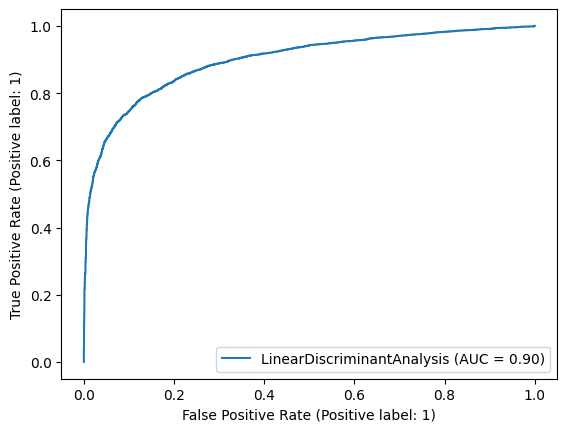

In [138]:
import matplotlib.pyplot as plt
plot_roc_curve(ldah,lda_X_test,lda_y_test,drop_intermediate=False)
plt.show()

### K Nearest Neighbors Classifier

In [139]:
from sklearn.neighbors import KNeighborsClassifier

In [140]:
# Función vista en clase para identificar el número de Ks "ideal/sugerido" que
# definimos como entrada para obtener el valor de error mínimo.
error_rate = []

for i in range(1,20):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

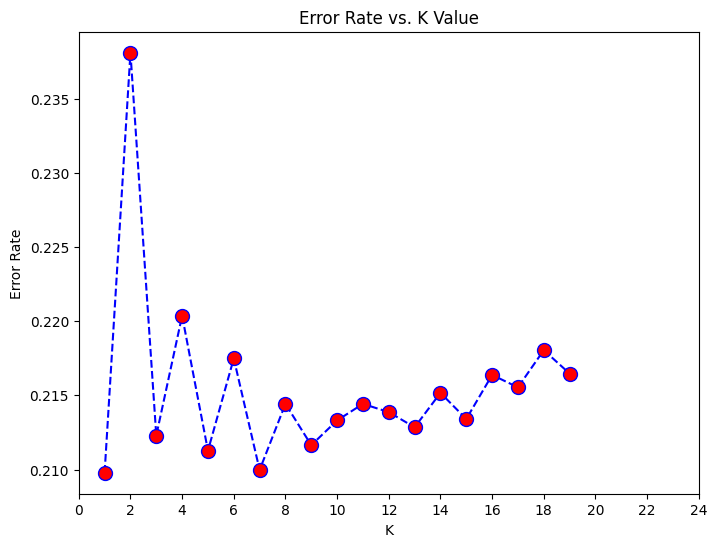

In [141]:
# Identificamos que el rango sugerido para los valores que puede adoptar "k" van de "1 a 4"
plt.figure(figsize=(8,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.xticks(np.arange(0, 25, 2));
plt.show()

In [146]:
knn_X_train=X_train
knn_y_train=y_train
knn_X_test=X_test
knn_y_test=y_test

In [147]:
knn = KNeighborsClassifier(n_neighbors= 1)

In [148]:
knn.fit(knn_X_train,knn_y_train)

KNeighborsClassifier(n_neighbors=1)

In [149]:
pred_knn = knn.predict(knn_X_test)
pred_knn

array([1, 1, 1, ..., 0, 1, 1], dtype=int64)

In [150]:
metricas(knn,knn_X_train,knn_y_train)

 Roc Validate: 1.000
 Acc Validate: 1.000
 Matrix Conf Validate:  
 [[12031     0]
 [    0 13106]]


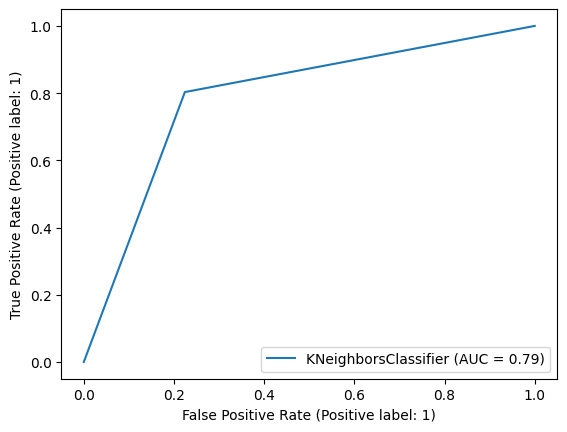

In [151]:
plot_roc_curve(knn,knn_X_test,knn_y_test,drop_intermediate=False)
plt.show()

In [152]:
print('--K Nearest Neighbors Classifier--')
print('\n')
print(confusion_matrix(knn_y_test,pred_knn))

print('\n')
print(classification_report(knn_y_test,pred_knn))

--K Nearest Neighbors Classifier--


[[3964 1145]
 [1115 4549]]


              precision    recall  f1-score   support

           0       0.78      0.78      0.78      5109
           1       0.80      0.80      0.80      5664

    accuracy                           0.79     10773
   macro avg       0.79      0.79      0.79     10773
weighted avg       0.79      0.79      0.79     10773



### Hiperparametrizando - KNeighborsClassifier

In [153]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'p': 2,
 'weights': 'uniform'}

In [154]:
param_grid_knn = {
    'n_neighbors' : [5,7,9,11,13,15],
    'weights' : ['uniform','distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric' : ['minkowski','euclidean','manhattan'],
    'p':[2]
}

In [155]:
np.prod(list(map(len, param_grid_knn.values())))

144

In [156]:
knnc = RandomizedSearchCV(knn, param_grid_knn, cv=4, error_score=-1000, n_jobs=-1, scoring= 'accuracy', verbose= 5)
knnc.fit(X_train, y_train)
print("Best score: " + str(knnc.best_score_))

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best score: 0.8051475708027407


In [157]:
knnc.best_estimator_

KNeighborsClassifier(algorithm='ball_tree', metric='euclidean', n_neighbors=13,
                     weights='distance')

In [158]:
knnc.best_params_

{'weights': 'distance',
 'p': 2,
 'n_neighbors': 13,
 'metric': 'euclidean',
 'algorithm': 'ball_tree'}

In [159]:
dc_scores={}

In [160]:
dc_scores[str(knnc).split("(")[0]] = {'model': knnc.best_estimator_, 'score': knnc.best_score_}
dc_scores

{'RandomizedSearchCV': {'model': KNeighborsClassifier(algorithm='ball_tree', metric='euclidean', n_neighbors=13,
                       weights='distance'),
  'score': 0.8051475708027407}}

In [166]:
# Usando los hiperparametros para el modelo
knnh = KNeighborsClassifier(weights= 'distance',p=2,n_neighbors=13,metric='manhattan',algorithm='auto')
knnh.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=13, weights='distance')

In [162]:
knnh_X_train=X_train
knnh_y_train=y_train
knnh_X_test=X_test
knnh_y_test=y_test

In [163]:
pred_knn = knn.predict(knnh_X_test)
pred_knn

array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

In [164]:
metricas(knn,knnh_X_train,knnh_y_train)

 Roc Validate: 1.000
 Acc Validate: 1.000
 Matrix Conf Validate:  
 [[12031     0]
 [    0 13106]]


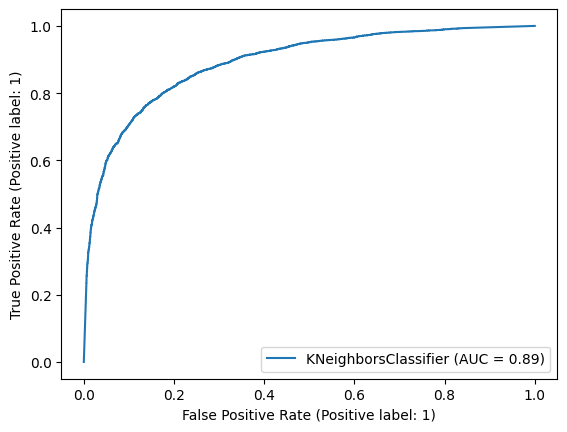

In [167]:
plot_roc_curve(knnh,knnh_X_test,knnh_y_test,drop_intermediate=False)
plt.show()

### Support Vector Machines (SVM)

In [179]:
from sklearn.svm import SVC

In [180]:
svm_class = SVC(kernel = 'rbf', probability= True)

In [181]:
svm_class.fit(X_train, y_train)

SVC(probability=True)

In [182]:
metricas(svm_class,X_train,y_train)

 Roc Validate: 0.785
 Acc Validate: 0.710
 Matrix Conf Validate:  
 [[9082 2949]
 [4343 8763]]


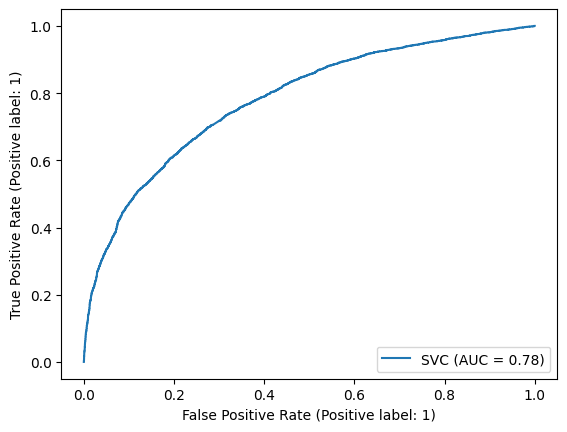

In [183]:
plot_roc_curve(svm_class,X_test,y_test,drop_intermediate=False)
plt.show()

### Naive Bayes Classifier

In [168]:
from sklearn.feature_selection import SelectKBest, f_classif

In [169]:
kb = SelectKBest(k = 10, score_func = f_classif)

In [170]:
from sklearn.naive_bayes import MultinomialNB

In [171]:
bayes=MultinomialNB()

In [172]:
bayes.fit(X_train, y_train,)

MultinomialNB()

In [173]:
metricas(bayes,X_test, y_test)

 Roc Validate: 0.753
 Acc Validate: 0.686
 Matrix Conf Validate:  
 [[2965 2144]
 [1240 4424]]


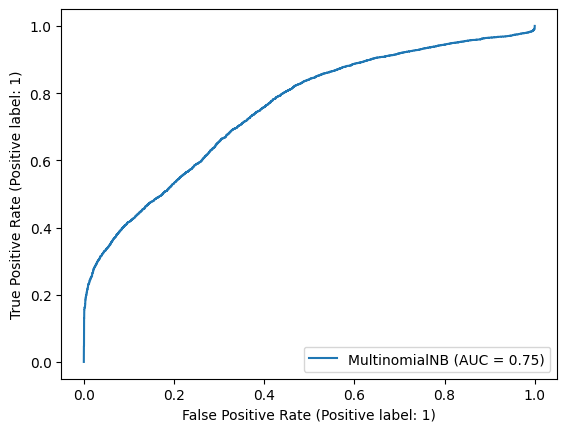

In [176]:
plot_roc_curve(bayes,X_test,y_test,drop_intermediate=False)
plt.show()

## Aplicando Transformaciones a 'test_set' y Modelado

In [268]:
# Verificamos la dimensión del test_set y mostramos primeros 2 registros para visualizar variabes que la componen
print(df_test.shape)
df_test.head(2)

(8980, 16)


,title,text,subject,clean_title,title_tokens,clean_text,text_tokens,lemma_title,lemma_text,n_dots,n_letters,n_lower_ratio_letters,n_upper_ratio_letters,n_words_title,n_words_text,n_emojis
0,Vietnam police arrest ex-politburo member over...,HANOI (Reuters) - Vietnamese police on Friday ...,worldnews,vietnam police arrest ex politburo member over...,"[vietnam, police, arrest, ex, politburo, membe...",hanoi reuters vietnamese police on friday arre...,"[hanoi, reuters, vietnamese, police, on, frida...",vietnam police arrest ex politburo member over...,hanoi reuters vietnamese police on friday arre...,17,2143,0.95660,0.95660,8,418,0
1,IS FOX ABOUT TO BECOME CNN? Leftist Wives Of L...,It is difficult to exaggerate the significance...,left-news,is fox about to become cnn leftist wives of li...,"[is, fox, about, to, become, cnn, leftist, wiv...",it is difficult to exaggerate the significance...,"[it, is, difficult, to, exaggerate, the, signi...",is fox about to become cnn leftist wife of lib...,it is difficult to exaggerate the significance...,56,6565,0.95476,0.95476,22,1438,0


In [269]:
# Verificamos presencia y cantidad de valores nulos
df_test.isnull().sum()

title                    0
text                     0
subject                  0
clean_title              0
title_tokens             0
clean_text               0
text_tokens              0
lemma_title              0
lemma_text               0
n_dots                   0
n_letters                0
n_lower_ratio_letters    0
n_upper_ratio_letters    0
n_words_title            0
n_words_text             0
n_emojis                 0
dtype: int64

In [270]:
# Identificamos proporción de variable 'subject'
df_test['subject'].value_counts(1)

politicsNews      0.24777
worldnews         0.22851
News              0.19811
politics          0.15479
left-news         0.09733
Government News   0.03519
Middle-east       0.01938
US_News           0.01893
Name: subject, dtype: float64

In [271]:
# Aplicamos las mismas transformaciónes de training_set
df_test['clean_title']= df_test['title'].map(clean_words)
df_test['title_tokens']= df_test['clean_title'].apply(lambda x:tokenizer.tokenize(x.lower()))
df_test['clean_text']= df_test['text'].map(clean_words)
df_test['text_tokens']= df_test['clean_text'].apply(lambda x:tokenizer.tokenize(x.lower()))
df_test['lemma_title']=df_test['title_tokens'].apply(lambda x:word_lemmatizer(x))
df_test['lemma_text']=df_test['text_tokens'].apply(lambda x:word_lemmatizer(x))
df_test['n_dots'] = df_test['text'].map(lambda x: x.count('.'))
df_test['n_letters'] = df_test['text'].map(lambda x:sum(map(str.isalpha, x)))
df_test['n_lower_ratio_letters'] = df_test['text'].map(lambda x:sum(map(str.islower, x))) / df_test['n_letters']
df_test['n_upper_ratio_letters'] = df_test['text'].map(lambda x:sum(map(str.isupper, x))) / df_test['n_letters']
df_test['n_words_title']= df_test['clean_title'].str.split().map(len)
df_test['n_words_text']= df_test['clean_text'].str.split().map(len)
df_test['n_emojis'] = df_test['text'].map(emoji.emoji_count)
df_test.head(3)

,title,text,subject,clean_title,title_tokens,clean_text,text_tokens,lemma_title,lemma_text,n_dots,n_letters,n_lower_ratio_letters,n_upper_ratio_letters,n_words_title,n_words_text,n_emojis
0,Vietnam police arrest ex-politburo member over...,HANOI (Reuters) - Vietnamese police on Friday ...,worldnews,vietnam police arrest ex politburo member over...,"[vietnam, police, arrest, ex, politburo, membe...",hanoi reuters vietnamese police on friday arre...,"[hanoi, reuters, vietnamese, police, on, frida...",vietnam police arrest ex politburo member over...,hanoi reuters vietnamese police on friday arre...,17,2143,0.95660,0.04340,8,418,0
1,IS FOX ABOUT TO BECOME CNN? Leftist Wives Of L...,It is difficult to exaggerate the significance...,left-news,is fox about to become cnn leftist wives of li...,"[is, fox, about, to, become, cnn, leftist, wiv...",it is difficult to exaggerate the significance...,"[it, is, difficult, to, exaggerate, the, signi...",is fox about to become cnn leftist wife of lib...,it is difficult to exaggerate the significance...,56,6565,0.95476,0.04524,22,1438,0
2,North Carolina Tea Partiers Just ADMITTED The...,Since Donald Trump began his run for the presi...,News,north carolina tea partiers just admitted they...,"[north, carolina, tea, partiers, just, admitte...",since donald trump began his run for the presi...,"[since, donald, trump, began, his, run, for, t...",north carolina tea partiers just admitted they...,since donald trump began his run for the presi...,25,2456,0.96295,0.03705,15,541,0


In [272]:
# Vemos los nombres de las columnas de df_test
df_test.columns

Index(['title', 'text', 'subject', 'clean_title', 'title_tokens', 'clean_text',
       'text_tokens', 'lemma_title', 'lemma_text', 'n_dots', 'n_letters',
       'n_lower_ratio_letters', 'n_upper_ratio_letters', 'n_words_title',
       'n_words_text', 'n_emojis'],
      dtype='object')

In [273]:
# Separamos variables continuas para su análisis
ls_features=['n_dots', 'n_letters', 'n_lower_ratio_letters',
       'n_upper_ratio_letters', 'n_words_title', 'n_words_text', 'n_emojis']

In [274]:
# Nuevamente verificamos valores nulos
df_test[ls_features].isnull().sum()

n_dots                     0
n_letters                  0
n_lower_ratio_letters    121
n_upper_ratio_letters    121
n_words_title              0
n_words_text               0
n_emojis                   0
dtype: int64

In [275]:
# Imputamos valores nulos con 0
df_test['n_lower_ratio_letters']= df_test['n_lower_ratio_letters'].fillna(value= 0)
df_test['n_upper_ratio_letters']= df_test['n_lower_ratio_letters'].fillna(value= 0)

In [276]:
# Nuevamente verificamos presencia de valores nulos para garantizar que la operación fue aplicada
df_test[ls_features].isnull().sum()

n_dots                   0
n_letters                0
n_lower_ratio_letters    0
n_upper_ratio_letters    0
n_words_title            0
n_words_text             0
n_emojis                 0
dtype: int64

In [281]:
X = df_train['clean_text'].values
y = df_train['fake_not'].values

In [282]:
cv = TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 1), min_df=10, max_features=100)
X = cv.fit_transform(X)

### Regresión Logística

In [283]:
clf = LogisticRegression(C=0.3,penalty='l1',solver='liblinear')
clf.fit(X, y)

LogisticRegression(C=0.3, penalty='l1', solver='liblinear')

In [284]:
y_pred_train = clf.predict(X)
accuracy_train = accuracy_score(y,y_pred_train)
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf,X = X,y= y , cv = 10)

In [285]:
print("Accuracy score on training data: ", accuracy_train)
print("Accuracy: {:.4f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.4f}".format(accuracies.std()*100))

Accuracy score on training data:  0.9925090504037872
Accuracy: 99.2286 %
Standard Deviation: 0.1324


In [286]:
X_test = df_test['clean_text']
X_test = cv.transform(X_test)

In [288]:
y_pred_final = clf.predict(X_test)
print(y_pred_final)

[0 1 1 ... 0 1 1]


In [289]:
y_pred_final.shape

(8980,)

In [292]:
metricas(clf,X_test,y_pred_final)

 Roc Validate: 1.000
 Acc Validate: 1.000
 Matrix Conf Validate:  
 [[4243    0]
 [   0 4737]]


## Clonclusiones

* Se consideró el modelo de Regresión Logística con una exactitud del 99% en el conjunto de entrenamiento, y un desempeño en el conjunto de prueba del 98% para las 8,980 noticias no vistas.
* Como vemos en los resultados de la matriz de confusión, el modelo seleccionado indica que tiene la capacidad de identificar todas la notas contenidas en el conjunto de prueba a partir de los valores obtenidos de la hiperparametrización. Sin embargo, este resultado salta a la vista de sospechoso, pues seguramente se requiere identificar dentro de las etapas de pre-procesamiento algún error que se encuentré ocasionando esto.
* Otra observación importante, y que vale la pena explorar es incluir el contenido del título de la nota dentro de todo el texto que se tomará como entrada para el modelo. Pues en algunos casos, el título de las publicaciones traen contenido incongruente que ayudaría a denotar con mayor certeza si la nota es falsa o no.
* Otra buena práctica para mejorar la identificación de noticias falsas, está relacionada con el análisis humano propiamente del negocio/empresa, en donde una persona o grupo de ellas se encarga de revisar de forma manual toda la estructura de la nota y con base a su experiencia taggearla como falsa o verdadera.
* Del punto anterior se puede obtener un conjunto de palabras y/o frases clave que previamente sean identificadas en noticias falsas y pueden ser de mucha utilidad para taggear nuevas notas.
